# Mistral vs LLama 2 vs Gemma

### Import Libraries

In [ ]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import pandas as pd
import utils

from dotenv import load_dotenv
from datasets import load_dataset
from generator.generator import Generator

llama = Generator(model='llama')
mistral = Generator(model='mistral')
gemma = Generator(model='gemma')

load_dotenv('env/var.env')

### Load Q&A Data 

In [3]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

### Create dictionary to save metrics

In [26]:
llama_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

mistral_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

gemma_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

### Gather metrics

In [ ]:
for i in range(60):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    # llama
    answer_llama, words_per_second, words = utils.get_llm_response(llama, context, query)
    llama_metrics["words_per_second"].append(words_per_second)
    llama_metrics["words"].append(words)

    # mistral
    answer_mistral, words_per_second, words = utils.get_llm_response(mistral, context, query)
    mistral_metrics["words_per_second"].append(words_per_second)
    mistral_metrics["words"].append(words)

    # gemma
    answer_gemma, words_per_second, words = utils.get_llm_response(gemma, context, query)
    gemma_metrics["words_per_second"].append(words_per_second)
    gemma_metrics["words"].append(words)

    # GPT-3.5 rank
    llm_answers_dict = {'llama': answer_llama, 'mistral': answer_mistral, 'gemma': answer_gemma}
    rank = utils.get_gpt_rank(answer, llm_answers_dict, os.getenv("OPENAI_API_KEY"))

    llama_metrics["rank"].append(rank.index('1')+1)
    mistral_metrics["rank"].append(rank.index('2')+1)
    gemma_metrics["rank"].append(rank.index('3')+1)
    

### Metrics comparison

#### Mistral 7B vs Llama 2 7B vs Gemma 7B

In [34]:
mistral_metrics = pd.DataFrame(mistral_metrics)
mistral_metrics['model'] = 'Mistral 7B'
llama_metrics = pd.DataFrame(llama_metrics)
llama_metrics['model'] = 'Llama 3 8B'
gemma_metrics = pd.DataFrame(gemma_metrics)
gemma_metrics['model'] = 'Gemma 7B'

# create single data frame for plotting
metrics = pd.concat([mistral_metrics, llama_metrics, gemma_metrics])

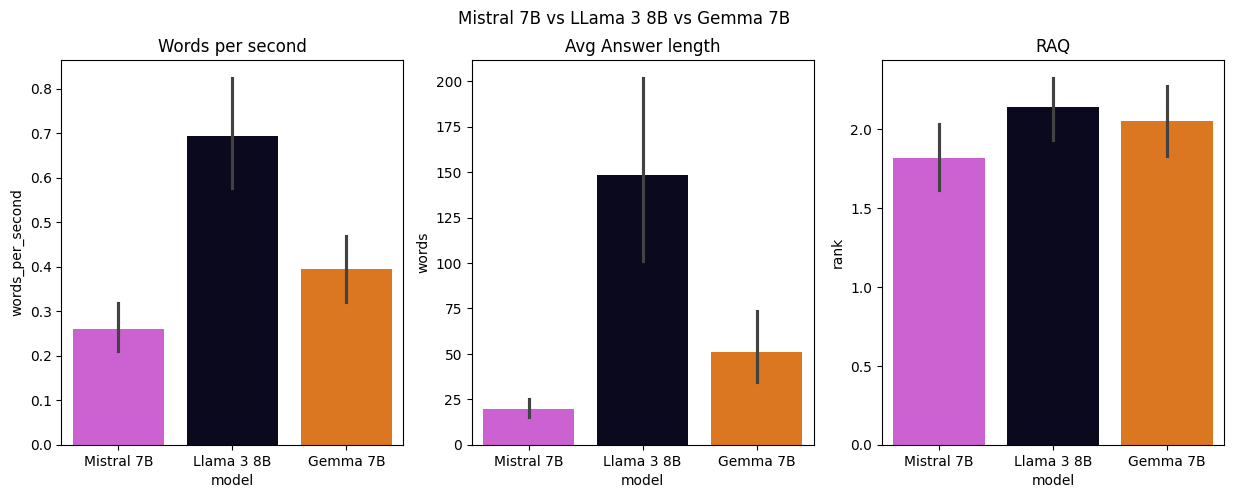

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Mistral 7B vs LLama 3 8B vs Gemma 7B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302"])
axes[1].set_title("Avg Answer length")

sns.barplot(ax=axes[2], data=metrics, y='rank', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302"])
axes[2].set_title("RAQ")

plt.show()

# Statiscal Test
 - Check if p_values are higher than the level of significance:
    - false means that two groups are statistically different.

In [39]:
p_values = sp.posthoc_dunn([llama_metrics['rank'], mistral_metrics['rank'], gemma_metrics['rank']], p_adjust='holm')
p_values > 0.05

,1,2,3
1,True,True,True
2,True,True,True
3,True,True,True
